# 훼손 및 블러링 이미지 데이터 품질 향상 (Image Deblurring)
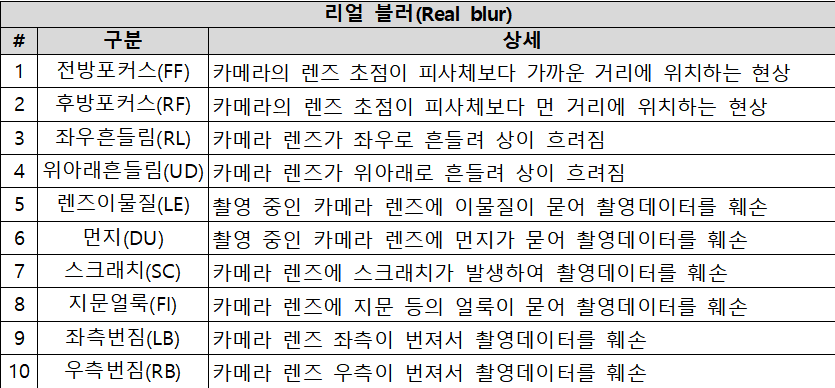

In [10]:
!pip install opencv-python==4.8.0.74
!pip install timm
!pip install torcheval

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
DEPRECATION: devscripts 2.22.1ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 18.0 MB/s eta 0:00:00a 0:00:01
DEPRECATION: devscripts 2.22.1ubuntu1 has a non-standard v

### Seed 고정

In [1]:
import torch
import random
import numpy as np

def set_seed(seed):
    random.seed(seed)                           # Python의 random 시드 설정
    np.random.seed(seed)                        # Numpy의 random 시드 설정
    torch.manual_seed(seed)                     # PyTorch CPU 시드 설정
    torch.cuda.manual_seed(seed)                # PyTorch GPU 시드 설정
    torch.cuda.manual_seed_all(seed)            # 모든 GPU의 시드를 설정 (멀티 GPU 환경)
    
    # CuDNN의 비결정적 연산을 방지하여 재현성을 높입니다.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
random_state = 42

# GPU 사용 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CFG = {
    'EPOCHS':10,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':1,
}

## Define Model Architecture

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pdb import set_trace as stx
import numbers

from einops import rearrange



##########################################################################
## Layer Norm

def to_3d(x):
    return rearrange(x, 'b c h w -> b (h w) c')

def to_4d(x,h,w):
    return rearrange(x, 'b (h w) c -> b c h w',h=h,w=w)

class BiasFree_LayerNorm(nn.Module):
    def __init__(self, normalized_shape):
        super(BiasFree_LayerNorm, self).__init__()
        if isinstance(normalized_shape, numbers.Integral):
            normalized_shape = (normalized_shape,)
        normalized_shape = torch.Size(normalized_shape)

        assert len(normalized_shape) == 1

        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.normalized_shape = normalized_shape

    def forward(self, x):
        sigma = x.var(-1, keepdim=True, unbiased=False)
        return x / torch.sqrt(sigma+1e-5) * self.weight

class WithBias_LayerNorm(nn.Module):
    def __init__(self, normalized_shape):
        super(WithBias_LayerNorm, self).__init__()
        if isinstance(normalized_shape, numbers.Integral):
            normalized_shape = (normalized_shape,)
        normalized_shape = torch.Size(normalized_shape)

        assert len(normalized_shape) == 1

        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.normalized_shape = normalized_shape

    def forward(self, x):
        mu = x.mean(-1, keepdim=True)
        sigma = x.var(-1, keepdim=True, unbiased=False)
        return (x - mu) / torch.sqrt(sigma+1e-5) * self.weight + self.bias


class LayerNorm(nn.Module):
    def __init__(self, dim, LayerNorm_type):
        super(LayerNorm, self).__init__()
        if LayerNorm_type =='BiasFree':
            self.body = BiasFree_LayerNorm(dim)
        else:
            self.body = WithBias_LayerNorm(dim)

    def forward(self, x):
        h, w = x.shape[-2:]
        return to_4d(self.body(to_3d(x)), h, w)



##########################################################################
## Gated-Dconv Feed-Forward Network (GDFN)
class FeedForward(nn.Module):
    def __init__(self, dim, ffn_expansion_factor, bias):
        super(FeedForward, self).__init__()

        hidden_features = int(dim*ffn_expansion_factor)

        self.project_in = nn.Conv2d(dim, hidden_features*2, kernel_size=1, bias=bias)

        self.dwconv = nn.Conv2d(hidden_features*2, hidden_features*2, kernel_size=3, stride=1, padding=1, groups=hidden_features*2, bias=bias)

        self.project_out = nn.Conv2d(hidden_features, dim, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.project_in(x)
        x1, x2 = self.dwconv(x).chunk(2, dim=1)
        x = F.gelu(x1) * x2
        x = self.project_out(x)
        return x



##########################################################################
## Multi-DConv Head Transposed Self-Attention (MDTA)
class Attention(nn.Module):
    def __init__(self, dim, num_heads, bias):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        self.temperature = nn.Parameter(torch.ones(num_heads, 1, 1))

        self.qkv = nn.Conv2d(dim, dim*3, kernel_size=1, bias=bias)
        self.qkv_dwconv = nn.Conv2d(dim*3, dim*3, kernel_size=3, stride=1, padding=1, groups=dim*3, bias=bias)
        self.project_out = nn.Conv2d(dim, dim, kernel_size=1, bias=bias)
        


    def forward(self, x):
        b,c,h,w = x.shape

        qkv = self.qkv_dwconv(self.qkv(x))
        q,k,v = qkv.chunk(3, dim=1)   
        
        q = rearrange(q, 'b (head c) h w -> b head c (h w)', head=self.num_heads)
        k = rearrange(k, 'b (head c) h w -> b head c (h w)', head=self.num_heads)
        v = rearrange(v, 'b (head c) h w -> b head c (h w)', head=self.num_heads)

        q = torch.nn.functional.normalize(q, dim=-1)
        k = torch.nn.functional.normalize(k, dim=-1)

        attn = (q @ k.transpose(-2, -1)) * self.temperature
        attn = attn.softmax(dim=-1)

        out = (attn @ v)
        
        out = rearrange(out, 'b head c (h w) -> b (head c) h w', head=self.num_heads, h=h, w=w)

        out = self.project_out(out)
        return out



##########################################################################
class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, ffn_expansion_factor, bias, LayerNorm_type):
        super(TransformerBlock, self).__init__()

        self.norm1 = LayerNorm(dim, LayerNorm_type)
        self.attn = Attention(dim, num_heads, bias)
        self.norm2 = LayerNorm(dim, LayerNorm_type)
        self.ffn = FeedForward(dim, ffn_expansion_factor, bias)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.ffn(self.norm2(x))

        return x



##########################################################################
## Overlapped image patch embedding with 3x3 Conv
class OverlapPatchEmbed(nn.Module):
    def __init__(self, in_c=3, embed_dim=48, bias=False):
        super(OverlapPatchEmbed, self).__init__()

        self.proj = nn.Conv2d(in_c, embed_dim, kernel_size=3, stride=1, padding=1, bias=bias)

    def forward(self, x):
        x = self.proj(x)

        return x



##########################################################################
## Resizing modules
class Downsample(nn.Module):
    def __init__(self, n_feat):
        super(Downsample, self).__init__()

        self.body = nn.Sequential(nn.Conv2d(n_feat, n_feat//2, kernel_size=3, stride=1, padding=1, bias=False),
                                  nn.PixelUnshuffle(2))

    def forward(self, x):
        return self.body(x)

class Upsample(nn.Module):
    def __init__(self, n_feat):
        super(Upsample, self).__init__()

        self.body = nn.Sequential(nn.Conv2d(n_feat, n_feat*2, kernel_size=3, stride=1, padding=1, bias=False),
                                  nn.PixelShuffle(2))

    def forward(self, x):
        return self.body(x)

##########################################################################
##---------- Restormer -----------------------
class Restormer(nn.Module):
    def __init__(self, 
        inp_channels=3, 
        out_channels=3, 
        dim = 48,
        num_blocks = [4,6,6,8], 
        num_refinement_blocks = 4,
        heads = [1,2,4,8],
        ffn_expansion_factor = 2.66,
        bias = False,
        LayerNorm_type = 'WithBias',   ## Other option 'BiasFree'
        dual_pixel_task = False        ## True for dual-pixel defocus deblurring only. Also set inp_channels=6
    ):

        super(Restormer, self).__init__()

        self.patch_embed = OverlapPatchEmbed(inp_channels, dim)

        self.encoder_level1 = nn.Sequential(*[TransformerBlock(dim=dim, num_heads=heads[0], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[0])])
        
        self.down1_2 = Downsample(dim) ## From Level 1 to Level 2
        self.encoder_level2 = nn.Sequential(*[TransformerBlock(dim=int(dim*2**1), num_heads=heads[1], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[1])])
        
        self.down2_3 = Downsample(int(dim*2**1)) ## From Level 2 to Level 3
        self.encoder_level3 = nn.Sequential(*[TransformerBlock(dim=int(dim*2**2), num_heads=heads[2], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[2])])

        self.down3_4 = Downsample(int(dim*2**2)) ## From Level 3 to Level 4
        self.latent = nn.Sequential(*[TransformerBlock(dim=int(dim*2**3), num_heads=heads[3], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[3])])
        
        self.up4_3 = Upsample(int(dim*2**3)) ## From Level 4 to Level 3
        self.reduce_chan_level3 = nn.Conv2d(int(dim*2**3), int(dim*2**2), kernel_size=1, bias=bias)
        self.decoder_level3 = nn.Sequential(*[TransformerBlock(dim=int(dim*2**2), num_heads=heads[2], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[2])])


        self.up3_2 = Upsample(int(dim*2**2)) ## From Level 3 to Level 2
        self.reduce_chan_level2 = nn.Conv2d(int(dim*2**2), int(dim*2**1), kernel_size=1, bias=bias)
        self.decoder_level2 = nn.Sequential(*[TransformerBlock(dim=int(dim*2**1), num_heads=heads[1], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[1])])
        
        self.up2_1 = Upsample(int(dim*2**1))  ## From Level 2 to Level 1  (NO 1x1 conv to reduce channels)

        self.decoder_level1 = nn.Sequential(*[TransformerBlock(dim=int(dim*2**1), num_heads=heads[0], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[0])])
        
        self.refinement = nn.Sequential(*[TransformerBlock(dim=int(dim*2**1), num_heads=heads[0], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_refinement_blocks)])
        
        #### For Dual-Pixel Defocus Deblurring Task ####
        self.dual_pixel_task = dual_pixel_task
        if self.dual_pixel_task:
            self.skip_conv = nn.Conv2d(dim, int(dim*2**1), kernel_size=1, bias=bias)
        ###########################
            
        self.output = nn.Conv2d(int(dim*2**1), out_channels, kernel_size=3, stride=1, padding=1, bias=bias)

    def forward(self, inp_img):

        inp_enc_level1 = self.patch_embed(inp_img)
        out_enc_level1 = self.encoder_level1(inp_enc_level1)
        
        inp_enc_level2 = self.down1_2(out_enc_level1)
        out_enc_level2 = self.encoder_level2(inp_enc_level2)

        inp_enc_level3 = self.down2_3(out_enc_level2)
        out_enc_level3 = self.encoder_level3(inp_enc_level3) 

        inp_enc_level4 = self.down3_4(out_enc_level3)        
        latent = self.latent(inp_enc_level4) 
                        
        inp_dec_level3 = self.up4_3(latent)
        inp_dec_level3 = torch.cat([inp_dec_level3, out_enc_level3], 1)
        inp_dec_level3 = self.reduce_chan_level3(inp_dec_level3)
        out_dec_level3 = self.decoder_level3(inp_dec_level3) 

        inp_dec_level2 = self.up3_2(out_dec_level3)
        inp_dec_level2 = torch.cat([inp_dec_level2, out_enc_level2], 1)
        inp_dec_level2 = self.reduce_chan_level2(inp_dec_level2)
        out_dec_level2 = self.decoder_level2(inp_dec_level2) 

        inp_dec_level1 = self.up2_1(out_dec_level2)
        inp_dec_level1 = torch.cat([inp_dec_level1, out_enc_level1], 1)
        out_dec_level1 = self.decoder_level1(inp_dec_level1)
        
        out_dec_level1 = self.refinement(out_dec_level1)

        #### For Dual-Pixel Defocus Deblurring Task ####
        if self.dual_pixel_task:
            out_dec_level1 = out_dec_level1 + self.skip_conv(inp_enc_level1)
            out_dec_level1 = self.output(out_dec_level1)
        ###########################
        else:
            out_dec_level1 = self.output(out_dec_level1) + inp_img


        return out_dec_level1

In [3]:
restormer_arch = Restormer()

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numbers
from einops import rearrange


def to_3d(x):
    return rearrange(x, 'b c h w -> b (h w) c')


def to_4d(x, h, w):
    return rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)


class BiasFree_LayerNorm(nn.Module):
    def __init__(self, normalized_shape):
        super(BiasFree_LayerNorm, self).__init__()
        if isinstance(normalized_shape, numbers.Integral):
            normalized_shape = (normalized_shape,)
        normalized_shape = torch.Size(normalized_shape)

        assert len(normalized_shape) == 1

        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.normalized_shape = normalized_shape

    def forward(self, x):
        sigma = x.var(-1, keepdim=True, unbiased=False)
        return x / torch.sqrt(sigma + 1e-5) * self.weight


class WithBias_LayerNorm(nn.Module):
    def __init__(self, normalized_shape):
        super(WithBias_LayerNorm, self).__init__()
        if isinstance(normalized_shape, numbers.Integral):
            normalized_shape = (normalized_shape,)
        normalized_shape = torch.Size(normalized_shape)

        assert len(normalized_shape) == 1

        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.normalized_shape = normalized_shape

    def forward(self, x):
        mu = x.mean(-1, keepdim=True)
        sigma = x.var(-1, keepdim=True, unbiased=False)
        return (x - mu) / torch.sqrt(sigma + 1e-5) * self.weight + self.bias


class LayerNorm(nn.Module):
    def __init__(self, dim, LayerNorm_type):
        super(LayerNorm, self).__init__()
        if LayerNorm_type == 'BiasFree':
            self.body = BiasFree_LayerNorm(dim)
        else:
            self.body = WithBias_LayerNorm(dim)

    def forward(self, x):
        h, w = x.shape[-2:]
        return to_4d(self.body(to_3d(x)), h, w)


class DFFN(nn.Module):
    def __init__(self, dim, ffn_expansion_factor, bias):

        super(DFFN, self).__init__()

        hidden_features = int(dim * ffn_expansion_factor)

        self.patch_size = 8

        self.dim = dim
        self.project_in = nn.Conv2d(dim, hidden_features * 2, kernel_size=1, bias=bias)

        self.dwconv = nn.Conv2d(hidden_features * 2, hidden_features * 2, kernel_size=3, stride=1, padding=1,
                                groups=hidden_features * 2, bias=bias)

        self.fft = nn.Parameter(torch.ones((hidden_features * 2, 1, 1, self.patch_size, self.patch_size // 2 + 1)))
        self.project_out = nn.Conv2d(hidden_features, dim, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.project_in(x)
        x_patch = rearrange(x, 'b c (h patch1) (w patch2) -> b c h w patch1 patch2', patch1=self.patch_size,
                            patch2=self.patch_size)
        x_patch_fft = torch.fft.rfft2(x_patch.float())
        x_patch_fft = x_patch_fft * self.fft
        x_patch = torch.fft.irfft2(x_patch_fft, s=(self.patch_size, self.patch_size))
        x = rearrange(x_patch, 'b c h w patch1 patch2 -> b c (h patch1) (w patch2)', patch1=self.patch_size,
                      patch2=self.patch_size)
        x1, x2 = self.dwconv(x).chunk(2, dim=1)

        x = F.gelu(x1) * x2
        x = self.project_out(x)
        return x


class FSAS(nn.Module):
    def __init__(self, dim, bias):
        super(FSAS, self).__init__()

        self.to_hidden = nn.Conv2d(dim, dim * 6, kernel_size=1, bias=bias)
        self.to_hidden_dw = nn.Conv2d(dim * 6, dim * 6, kernel_size=3, stride=1, padding=1, groups=dim * 6, bias=bias)

        self.project_out = nn.Conv2d(dim * 2, dim, kernel_size=1, bias=bias)

        self.norm = LayerNorm(dim * 2, LayerNorm_type='WithBias')

        self.patch_size = 8

    def forward(self, x):
        hidden = self.to_hidden(x)

        q, k, v = self.to_hidden_dw(hidden).chunk(3, dim=1)

        q_patch = rearrange(q, 'b c (h patch1) (w patch2) -> b c h w patch1 patch2', patch1=self.patch_size,
                            patch2=self.patch_size)
        k_patch = rearrange(k, 'b c (h patch1) (w patch2) -> b c h w patch1 patch2', patch1=self.patch_size,
                            patch2=self.patch_size)
        q_fft = torch.fft.rfft2(q_patch.float())
        k_fft = torch.fft.rfft2(k_patch.float())

        out = q_fft * k_fft
        out = torch.fft.irfft2(out, s=(self.patch_size, self.patch_size))
        out = rearrange(out, 'b c h w patch1 patch2 -> b c (h patch1) (w patch2)', patch1=self.patch_size,
                        patch2=self.patch_size)

        out = self.norm(out)

        output = v * out
        output = self.project_out(output)

        return output


##########################################################################
class TransformerBlock(nn.Module):
    def __init__(self, dim, ffn_expansion_factor=2.66, bias=False, LayerNorm_type='WithBias', att=False):
        super(TransformerBlock, self).__init__()

        self.att = att
        if self.att:
            self.norm1 = LayerNorm(dim, LayerNorm_type)
            self.attn = FSAS(dim, bias)

        self.norm2 = LayerNorm(dim, LayerNorm_type)
        self.ffn = DFFN(dim, ffn_expansion_factor, bias)

    def forward(self, x):
        if self.att:
            x = x + self.attn(self.norm1(x))

        x = x + self.ffn(self.norm2(x))

        return x


class Fuse(nn.Module):
    def __init__(self, n_feat):
        super(Fuse, self).__init__()
        self.n_feat = n_feat
        self.att_channel = TransformerBlock(dim=n_feat * 2)

        self.conv = nn.Conv2d(n_feat * 2, n_feat * 2, 1, 1, 0)
        self.conv2 = nn.Conv2d(n_feat * 2, n_feat * 2, 1, 1, 0)

    def forward(self, enc, dnc):
        x = self.conv(torch.cat((enc, dnc), dim=1))
        x = self.att_channel(x)
        x = self.conv2(x)
        e, d = torch.split(x, [self.n_feat, self.n_feat], dim=1)
        output = e + d

        return output


##########################################################################
## Overlapped image patch embedding with 3x3 Conv
class OverlapPatchEmbed(nn.Module):
    def __init__(self, in_c=3, embed_dim=48, bias=False):
        super(OverlapPatchEmbed, self).__init__()

        self.proj = nn.Conv2d(in_c, embed_dim, kernel_size=3, stride=1, padding=1, bias=bias)

    def forward(self, x):
        x = self.proj(x)

        return x


##########################################################################
## Resizing modules
class Downsample(nn.Module):
    def __init__(self, n_feat):
        super(Downsample, self).__init__()

        self.body = nn.Sequential(nn.Upsample(scale_factor=0.5, mode='bilinear', align_corners=False),
                                  nn.Conv2d(n_feat, n_feat * 2, 3, stride=1, padding=1, bias=False))

    def forward(self, x):
        return self.body(x)


class Upsample(nn.Module):
    def __init__(self, n_feat):
        super(Upsample, self).__init__()

        self.body = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                                  nn.Conv2d(n_feat, n_feat // 2, 3, stride=1, padding=1, bias=False))

    def forward(self, x):
        return self.body(x)


##########################################################################
##---------- FFTformer -----------------------
class fftformer(nn.Module):
    def __init__(self,
                 inp_channels=3,
                 out_channels=3,
                 dim=48,
                 num_blocks=[6, 6, 12, 8],
                 num_refinement_blocks=4,
                 ffn_expansion_factor=3,
                 bias=False,
                 ):
        super(fftformer, self).__init__()

        self.patch_embed = OverlapPatchEmbed(inp_channels, dim)

        self.encoder_level1 = nn.Sequential(*[
            TransformerBlock(dim=dim, ffn_expansion_factor=ffn_expansion_factor, bias=bias) for i in
            range(num_blocks[0])])

        self.down1_2 = Downsample(dim)
        self.encoder_level2 = nn.Sequential(*[
            TransformerBlock(dim=int(dim * 2 ** 1), ffn_expansion_factor=ffn_expansion_factor,
                             bias=bias) for i in range(num_blocks[1])])

        self.down2_3 = Downsample(int(dim * 2 ** 1))
        self.encoder_level3 = nn.Sequential(*[
            TransformerBlock(dim=int(dim * 2 ** 2), ffn_expansion_factor=ffn_expansion_factor,
                             bias=bias) for i in range(num_blocks[2])])

        self.decoder_level3 = nn.Sequential(*[
            TransformerBlock(dim=int(dim * 2 ** 2), ffn_expansion_factor=ffn_expansion_factor,
                             bias=bias, att=True) for i in range(num_blocks[2])])

        self.up3_2 = Upsample(int(dim * 2 ** 2))
        self.reduce_chan_level2 = nn.Conv2d(int(dim * 2 ** 2), int(dim * 2 ** 1), kernel_size=1, bias=bias)
        self.decoder_level2 = nn.Sequential(*[
            TransformerBlock(dim=int(dim * 2 ** 1), ffn_expansion_factor=ffn_expansion_factor,
                             bias=bias, att=True) for i in range(num_blocks[1])])

        self.up2_1 = Upsample(int(dim * 2 ** 1))

        self.decoder_level1 = nn.Sequential(*[
            TransformerBlock(dim=int(dim), ffn_expansion_factor=ffn_expansion_factor,
                             bias=bias, att=True) for i in range(num_blocks[0])])

        self.refinement = nn.Sequential(*[
            TransformerBlock(dim=int(dim), ffn_expansion_factor=ffn_expansion_factor,
                             bias=bias, att=True) for i in range(num_refinement_blocks)])

        self.fuse2 = Fuse(dim * 2)
        self.fuse1 = Fuse(dim)
        self.output = nn.Conv2d(int(dim), out_channels, kernel_size=3, stride=1, padding=1, bias=bias)

    def forward(self, inp_img):
        inp_enc_level1 = self.patch_embed(inp_img)
        out_enc_level1 = self.encoder_level1(inp_enc_level1)

        inp_enc_level2 = self.down1_2(out_enc_level1)
        out_enc_level2 = self.encoder_level2(inp_enc_level2)

        inp_enc_level3 = self.down2_3(out_enc_level2)
        out_enc_level3 = self.encoder_level3(inp_enc_level3)

        out_dec_level3 = self.decoder_level3(out_enc_level3)

        inp_dec_level2 = self.up3_2(out_dec_level3)

        inp_dec_level2 = self.fuse2(inp_dec_level2, out_enc_level2)

        out_dec_level2 = self.decoder_level2(inp_dec_level2)

        inp_dec_level1 = self.up2_1(out_dec_level2)

        inp_dec_level1 = self.fuse1(inp_dec_level1, out_enc_level1)
        out_dec_level1 = self.decoder_level1(inp_dec_level1)

        out_dec_level1 = self.refinement(out_dec_level1)

        out_dec_level1 = self.output(out_dec_level1) + inp_img

        return out_dec_level1

In [5]:
fftformer_arch = fftformer()

In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from glob import glob
import timm
import torchvision
from tqdm import tqdm
import torch.nn.functional as F

# 데이터셋 경로
noisy_data_path = './open/test/Input'
output_path = './open/test/submission'

# 각 유형별로 리스트 초기화
test_ff_rf_paths = []
test_rl_ud_paths = []
test_sc_le_paths = []
test_lb_rb_du_fi_paths = []
test_other_paths = []  # 95% 확률 미만 이미지 리스트

# 이미지 파일 리스트 생성
test_all_image_paths = glob(os.path.join(noisy_data_path, '*.jpg'))

# 이미지 전처리 설정
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 불러오기
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 4)  # 4가지 블러 유형으로 분류하도록 출력층 수정
model.load_state_dict(torch.load("./resnet18_0.9621_90퍼.pth"))
model.eval()  # 평가 모드로 설정
model = model.to(device)

# 블러 유형 레이블 정의
blur_labels = {0: 'FF_RF', 1: 'RL_UD', 2: 'SC_LE', 3: 'LB_RB_DU_FI'}

# 예측 수행 및 이미지 분류
with torch.no_grad():
    for image_path in tqdm(test_all_image_paths, desc="Predicting Blur Types"):
        # 이미지 로드 및 전처리
        image = Image.open(image_path).convert('RGB')
        image = transform(image).unsqueeze(0).to(device)  # 배치 차원 추가

        # 모델 예측
        output = model(image)
        probabilities = F.softmax(output, dim=1)
        max_prob, predicted = torch.max(probabilities, 1)
        blur_type = blur_labels[predicted.item()]

        # 예측 결과에 따라 분류
        if max_prob.item() < 0.98:
            test_other_paths.append(image_path)  # 95% 확률 미만인 경우
        else:
            if blur_type == 'FF_RF':
                test_ff_rf_paths.append(image_path)
            elif blur_type == 'RL_UD':
                test_rl_ud_paths.append(image_path)
            elif blur_type == 'SC_LE':
                test_sc_le_paths.append(image_path)
            else:
                test_lb_rb_du_fi_paths.append(image_path)

# 결과 출력
print("FF, RF 블러 유형 이미지 파일 경로 리스트:", len(test_ff_rf_paths))
print("RL, UD 블러 유형 이미지 파일 경로 리스트:", len(test_rl_ud_paths))
print("SC, LE 블러 유형 이미지 파일 경로 리스트:", len(test_sc_le_paths))
print("기타 블러 유형 이미지 파일 경로 리스트:", len(test_lb_rb_du_fi_paths))
print("95% 확률 미만 이미지 파일 경로 리스트:", len(test_other_paths))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Predicting Blur Types: 100% 212/212 [00:01<00:00, 163.52it/s]

FF, RF 블러 유형 이미지 파일 경로 리스트: 26
RL, UD 블러 유형 이미지 파일 경로 리스트: 32
SC, LE 블러 유형 이미지 파일 경로 리스트: 20
기타 블러 유형 이미지 파일 경로 리스트: 73
95% 확률 미만 이미지 파일 경로 리스트: 61


In [7]:
###### 모델 테스트(추론) ######
import os
from os import listdir
from os.path import join, splitext
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Normalize, Compose
from PIL import Image

def load_img(filepath):
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

if not os.path.exists(output_path):
    os.makedirs(output_path)

class CustomDatasetTest(data.Dataset):
    def __init__(self, noisy_image_paths, transform=None):
        self.noisy_image_paths = noisy_image_paths #[join(noisy_image_paths, x) for x in listdir(noisy_image_paths)]
        self.transform = transform

    def __len__(self):
        return len(self.noisy_image_paths)

    def __getitem__(self, index):
        noisy_image_path = self.noisy_image_paths[index]
        noisy_image = load_img(self.noisy_image_paths[index])
        
        # Convert numpy array to PIL image
        if isinstance(noisy_image, np.ndarray):
            noisy_image = Image.fromarray(noisy_image)

        if self.transform:
            noisy_image = self.transform(noisy_image)

        return noisy_image, noisy_image_path
test_transform = Compose([
    ToTensor(),
])
test_transform_normalize = Compose([
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

test_ff_rf_dataset = CustomDatasetTest(test_ff_rf_paths, transform=test_transform)
test_ff_rf_loader = DataLoader(test_ff_rf_dataset, batch_size=CFG["BATCH_SIZE"], shuffle=False)    
test_rl_ud_dataset = CustomDatasetTest(test_rl_ud_paths, transform=test_transform)
test_rl_ud_loader = DataLoader(test_rl_ud_dataset, batch_size=CFG["BATCH_SIZE"], shuffle=False)    
test_sc_le_dataset = CustomDatasetTest(test_sc_le_paths, transform=test_transform_normalize)
test_sc_le_loader = DataLoader(test_sc_le_dataset, batch_size=CFG["BATCH_SIZE"], shuffle=False)   
test_lb_rb_du_fi_dataset = CustomDatasetTest(test_lb_rb_du_fi_paths, transform=test_transform_normalize)
test_lb_rb_du_fi_loader = DataLoader(test_lb_rb_du_fi_dataset, batch_size=CFG["BATCH_SIZE"], shuffle=False) 
test_other_dataset = CustomDatasetTest(test_other_paths, transform=test_transform_normalize)
test_other_loader = DataLoader(test_other_dataset, batch_size=CFG["BATCH_SIZE"], shuffle=False)  
    
ff_rf_model = restormer_arch.to(device)
ff_rf_model.load_state_dict(torch.load('./ff_rf_1080crop_without_amp.pth'))
rl_ud_model = fftformer_arch.to(device)
rl_ud_model.load_state_dict(torch.load('./rl_ud_1080crop_without_amp.pth'))
sc_le_model = fftformer_arch.to(device)
sc_le_model.load_state_dict(torch.load('./LE_SC_l1+edge_normalize.pth'))
lb_rb_du_fi_model = restormer_arch.to(device)
lb_rb_du_fi_model.load_state_dict(torch.load('./lb_rb_restormer_3epoch.pth'))
other_model = restormer_arch.to(device)
other_model.load_state_dict(torch.load('./best_Restormer.pth'))

# 이미지 denoising 및 저장
for noisy_image, noisy_image_path in test_ff_rf_loader:
    noisy_image = noisy_image.to(device)
    denoised_image = ff_rf_model(noisy_image)
    
    # denoised_image를 CPU로 이동하여 이미지 저장
    denoised_image = denoised_image.cpu().squeeze(0)
    denoised_image = torch.clamp(denoised_image, 0, 1)  # 이미지 값을 0과 1 사이로 클램핑
    denoised_image = transforms.ToPILImage()(denoised_image)

    # Save denoised image
    output_filename = noisy_image_path[0]
    denoised_filename = output_path + '/' + output_filename.split('/')[-1][:-4] + '.jpg'
    denoised_image.save(denoised_filename) 
    
    print(f'Saved denoised image: {denoised_filename}')

for noisy_image, noisy_image_path in test_rl_ud_loader:
    noisy_image = noisy_image.to(device)
    denoised_image = rl_ud_model(noisy_image)
    
    # denoised_image를 CPU로 이동하여 이미지 저장
    denoised_image = denoised_image.cpu().squeeze(0)
    denoised_image = (denoised_image).clamp(0, 1)  # 이미지 값을 0과 1 사이로 클램핑
    denoised_image = transforms.ToPILImage()(denoised_image)

    # Save denoised image
    output_filename = noisy_image_path[0]
    denoised_filename = output_path + '/' + output_filename.split('/')[-1][:-4] + '.jpg'
    denoised_image.save(denoised_filename) 
    
    print(f'Saved denoised image: {denoised_filename}')

for noisy_image, noisy_image_path in test_sc_le_loader:
    noisy_image = noisy_image.to(device)
    denoised_image = sc_le_model(noisy_image)
    
    # denoised_image를 CPU로 이동하여 이미지 저장
    denoised_image = denoised_image.cpu().squeeze(0)
    denoised_image = (denoised_image * 0.5 + 0.5).clamp(0, 1)  # 이미지 값을 0과 1 사이로 클램핑
    denoised_image = transforms.ToPILImage()(denoised_image)

    # Save denoised image
    output_filename = noisy_image_path[0]
    denoised_filename = output_path + '/' + output_filename.split('/')[-1][:-4] + '.jpg'
    denoised_image.save(denoised_filename) 
    
    print(f'Saved denoised image: {denoised_filename}')

for noisy_image, noisy_image_path in test_lb_rb_du_fi_loader:
    noisy_image = noisy_image.to(device)
    denoised_image = lb_rb_du_fi_model(noisy_image)
    
    # denoised_image를 CPU로 이동하여 이미지 저장
    denoised_image = denoised_image.cpu().squeeze(0)
    denoised_image = (denoised_image * 0.5 + 0.5).clamp(0, 1)  # 이미지 값을 0과 1 사이로 클램핑
    denoised_image = transforms.ToPILImage()(denoised_image)

    # Save denoised image
    output_filename = noisy_image_path[0]
    denoised_filename = output_path + '/' + output_filename.split('/')[-1][:-4] + '.jpg'
    denoised_image.save(denoised_filename) 
    
    print(f'Saved denoised image: {denoised_filename}')

for noisy_image, noisy_image_path in test_other_loader:
    noisy_image = noisy_image.to(device)
    denoised_image = other_model(noisy_image)
    
    # denoised_image를 CPU로 이동하여 이미지 저장
    denoised_image = denoised_image.cpu().squeeze(0)
    denoised_image = (denoised_image * 0.5 + 0.5).clamp(0, 1)  # 이미지 값을 0과 1 사이로 클램핑
    denoised_image = transforms.ToPILImage()(denoised_image)

    # Save denoised image
    output_filename = noisy_image_path[0]
    denoised_filename = output_path + '/' + output_filename.split('/')[-1][:-4] + '.jpg'
    denoised_image.save(denoised_filename) 
    
    print(f'Saved denoised image: {denoised_filename}')

Saved denoised image: ./open/test/submission/TEST_001.jpg
Saved denoised image: ./open/test/submission/TEST_002.jpg
Saved denoised image: ./open/test/submission/TEST_010.jpg
Saved denoised image: ./open/test/submission/TEST_011.jpg
Saved denoised image: ./open/test/submission/TEST_015.jpg
Saved denoised image: ./open/test/submission/TEST_019.jpg
Saved denoised image: ./open/test/submission/TEST_020.jpg
Saved denoised image: ./open/test/submission/TEST_034.jpg
Saved denoised image: ./open/test/submission/TEST_040.jpg
Saved denoised image: ./open/test/submission/TEST_041.jpg
Saved denoised image: ./open/test/submission/TEST_045.jpg
Saved denoised image: ./open/test/submission/TEST_052.jpg
Saved denoised image: ./open/test/submission/TEST_054.jpg
Saved denoised image: ./open/test/submission/TEST_059.jpg
Saved denoised image: ./open/test/submission/TEST_081.jpg
Saved denoised image: ./open/test/submission/TEST_083.jpg
Saved denoised image: ./open/test/submission/TEST_089.jpg
Saved denoised

Saved denoised image: ./open/test/submission/TEST_187.jpg
Saved denoised image: ./open/test/submission/TEST_188.jpg
Saved denoised image: ./open/test/submission/TEST_190.jpg
Saved denoised image: ./open/test/submission/TEST_194.jpg
Saved denoised image: ./open/test/submission/TEST_203.jpg
Saved denoised image: ./open/test/submission/TEST_205.jpg
Saved denoised image: ./open/test/submission/TEST_206.jpg
Saved denoised image: ./open/test/submission/TEST_210.jpg
Saved denoised image: ./open/test/submission/TEST_000.jpg
Saved denoised image: ./open/test/submission/TEST_003.jpg
Saved denoised image: ./open/test/submission/TEST_005.jpg
Saved denoised image: ./open/test/submission/TEST_006.jpg
Saved denoised image: ./open/test/submission/TEST_012.jpg
Saved denoised image: ./open/test/submission/TEST_013.jpg
Saved denoised image: ./open/test/submission/TEST_014.jpg
Saved denoised image: ./open/test/submission/TEST_018.jpg
Saved denoised image: ./open/test/submission/TEST_025.jpg
Saved denoised

In [8]:
import shutil

def zip_folder(folder_path, output_zip):
    shutil.make_archive(output_zip, 'zip', folder_path)
    print(f"Created {output_zip}.zip successfully.")

zip_folder(output_path, './final_submission')

Created ./final_submission.zip successfully.
